Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.losses import MeanSquaredLogarithmicError
from keras.models import load_model
import ast
# from keras.preprocessing.sequence import pad_sequences

Mounted at /content/drive


# Tensorflow Model Architecture (100m only)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/dataframe_100m_fast_trial_2.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})


,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 7799,Descriptors 7800,Descriptors 7801,Descriptors 7802,Descriptors 7803,Descriptors 7804,Descriptors 7805,Descriptors 7806,Descriptors 7807,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3222,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3223,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3224,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [ ]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 1613 rows with NaN values in the Feature Extraction column.
Found 1613 rows with NaN values in the Descriptors column.


In [ ]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MaxAbsScaler


X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])


scaler = MaxAbsScaler()

X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)

X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

# Add the layers with pooling and dropout
x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [ ]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [ ]:
hist = model.fit(X_train_padded, y_train, epochs= 300, batch_size=64, verbose = 1, callbacks=[reduce_lr,early_stop], validation_data = (X_test_padded, y_test))

Epoch 1/300
21/21 [==============================] - 7s 106ms/step - loss: 37.4873 - val_loss: 99.4960 - lr: 0.0010
Epoch 2/300
21/21 [==============================] - 2s 79ms/step - loss: 19.5522 - val_loss: 99.7120 - lr: 0.0010
Epoch 3/300
21/21 [==============================] - 2s 81ms/step - loss: 19.3152 - val_loss: 99.8895 - lr: 0.0010
Epoch 4/300
21/21 [==============================] - 2s 81ms/step - loss: 18.3886 - val_loss: 100.1786 - lr: 0.0010
Epoch 5/300
21/21 [==============================] - 2s 80ms/step - loss: 15.7136 - val_loss: 100.3983 - lr: 0.0010
Epoch 6/300
21/21 [==============================] - 2s 82ms/step - loss: 15.0720 - val_loss: 100.7466 - lr: 0.0010
Epoch 7/300
21/21 [==============================] - 2s 83ms/step - loss: 14.9790 - val_loss: 100.9081 - lr: 0.0010
Epoch 8/300
21/21 [==============================] - 2s 82ms/step - loss: 16.2083 - val_loss: 100.9488 - lr: 0.0010
Epoch 9/300
21/21 [==============================] - 2s 80ms/step - loss: 

Evaluate Model

In [ ]:
# Evaluate the model
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

11/11 [==============================] - 0s 11ms/step
MAPE: 0.2266751206393158


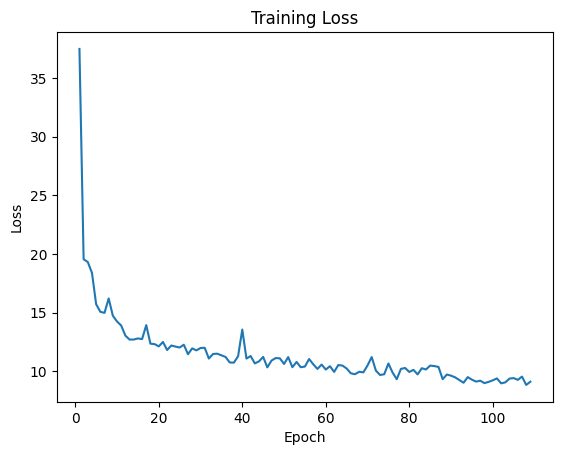

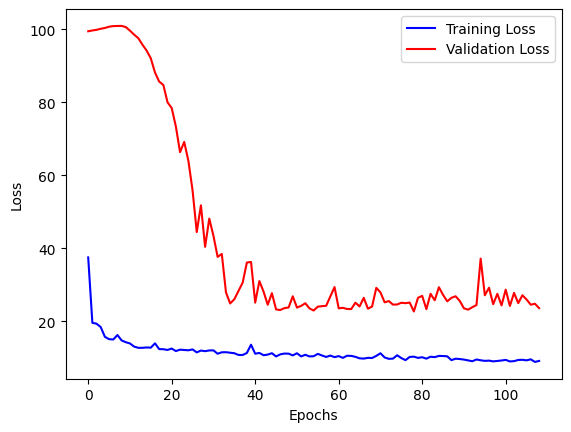

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting loss values from history
loss = hist.history['loss']

# Creating a Seaborn line plot
sns.lineplot(x=range(1, len(loss) + 1), y=loss)

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Displaying the plot
plt.show()

plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: -13.44369506561191
Mean Absolute Error (MAE): 5.7608333460096235
Root Mean Squared Error (RMSE): 32.17565302049237


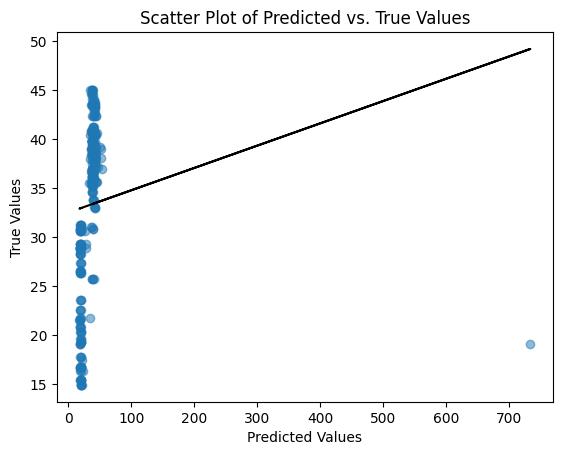

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.4967684922167165


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.4967684922167165
Mean Absolute Error (MAE): 4.822687506293013
Root Mean Squared Error (RMSE): 6.005817440793716
Mean Absolute Percentage Error (MAPE): 0.16922919918615653


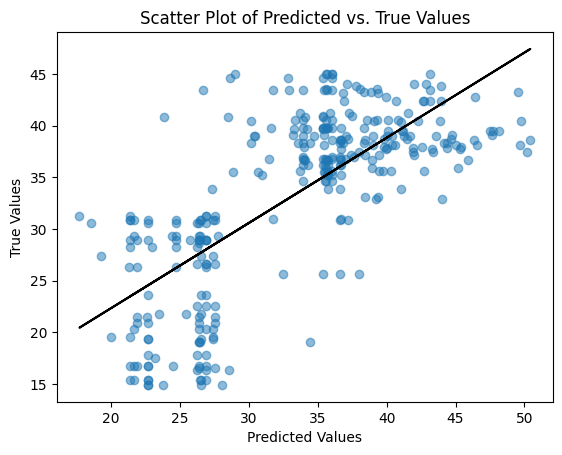

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.7304917954870588


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7304917954870588
Mean Absolute Error (MAE): 3.536482330733528
Root Mean Squared Error (RMSE): 4.395155143463492
Mean Absolute Percentage Error (MAPE): 0.1294766750797709


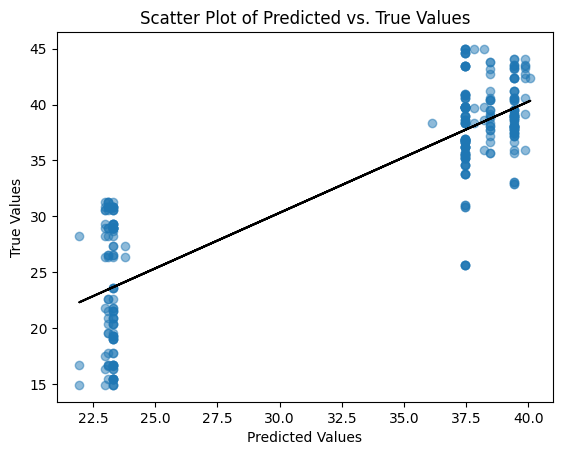

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
model_filename = 'model_fast_cobalagi.h5'

model.save('/content/drive/MyDrive/Skripsi/model/'+ model_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Tensorflow Model Architecture (50m only)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/dataframe_50m_fast_trial_2.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

df

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 8695,Descriptors 8696,Descriptors 8697,Descriptors 8698,Descriptors 8699,Descriptors 8700,Descriptors 8701,Descriptors 8702,Descriptors 8703,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3228,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3229,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3230,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [ ]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 1616 rows with NaN values in the Feature Extraction column.
Found 1616 rows with NaN values in the Descriptors column.


In [ ]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MaxAbsScaler



# Flatten the input sequences
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])

# Normalize the flattened sequences
scaler = MaxAbsScaler()

X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)

X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

# Add the layers with pooling and dropout
x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)


x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [ ]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [ ]:
hist = model.fit(X_train_padded, y_train, 
                 epochs= 300, 
                 batch_size=64, 
                 verbose = 1, 
                 callbacks=[reduce_lr,early_stop], 
                 validation_data = (X_test_padded, y_test))

Epoch 1/300
21/21 [==============================] - 5s 98ms/step - loss: 35.6811 - val_loss: 99.3282 - lr: 0.0010
Epoch 2/300
21/21 [==============================] - 1s 67ms/step - loss: 26.4549 - val_loss: 99.3994 - lr: 0.0010
Epoch 3/300
21/21 [==============================] - 1s 67ms/step - loss: 26.2156 - val_loss: 99.3846 - lr: 0.0010
Epoch 4/300
21/21 [==============================] - 1s 71ms/step - loss: 26.3432 - val_loss: 99.2793 - lr: 0.0010
Epoch 5/300
21/21 [==============================] - 1s 69ms/step - loss: 24.2720 - val_loss: 98.7657 - lr: 0.0010
Epoch 6/300
21/21 [==============================] - 1s 64ms/step - loss: 23.4718 - val_loss: 98.1252 - lr: 0.0010
Epoch 7/300
21/21 [==============================] - 1s 64ms/step - loss: 22.8471 - val_loss: 97.0991 - lr: 0.0010
Epoch 8/300
21/21 [==============================] - 1s 67ms/step - loss: 23.4207 - val_loss: 95.6932 - lr: 0.0010
Epoch 9/300
21/21 [==============================] - 1s 65ms/step - loss: 22.328

Evaluate Model

In [ ]:
# Evaluate the model
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

11/11 [==============================] - 0s 9ms/step
MAPE: 0.2475601395429161


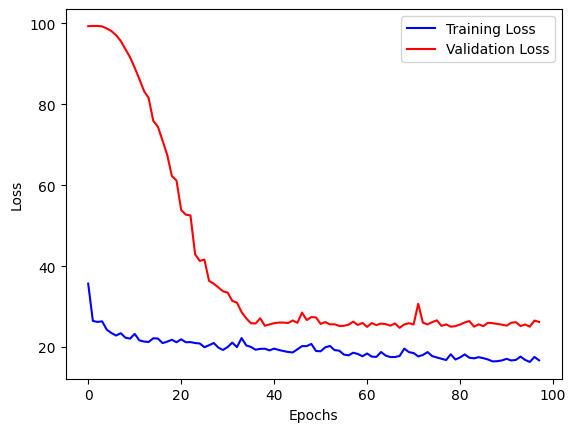

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: -0.5165319063411447
Mean Absolute Error (MAE): 7.421064447002647
Root Mean Squared Error (RMSE): 10.67658749731523


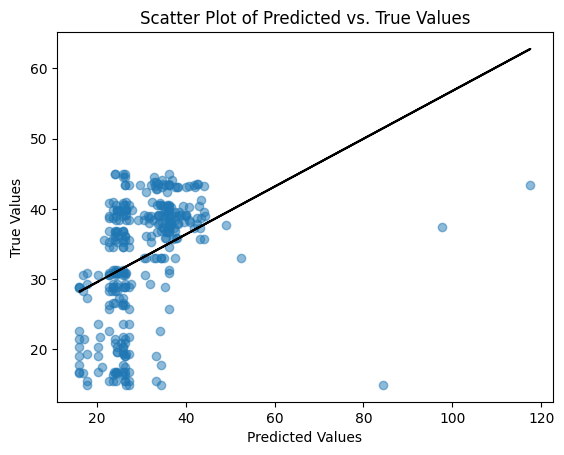

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.5727302863547958


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5727302863547958
Mean Absolute Error (MAE): 4.646859986167861
Root Mean Squared Error (RMSE): 5.667059108429558
Mean Absolute Percentage Error (MAPE): 0.1702656331679138


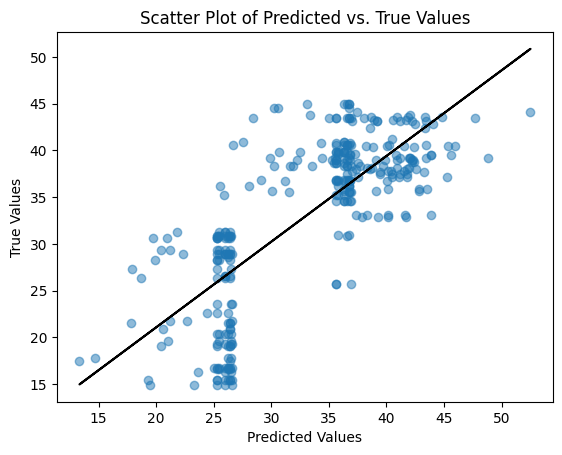

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.7136015025480651


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7136015025480651
Mean Absolute Error (MAE): 3.795297056894578
Root Mean Squared Error (RMSE): 4.639723022082182
Mean Absolute Percentage Error (MAPE): 0.1391993791848152


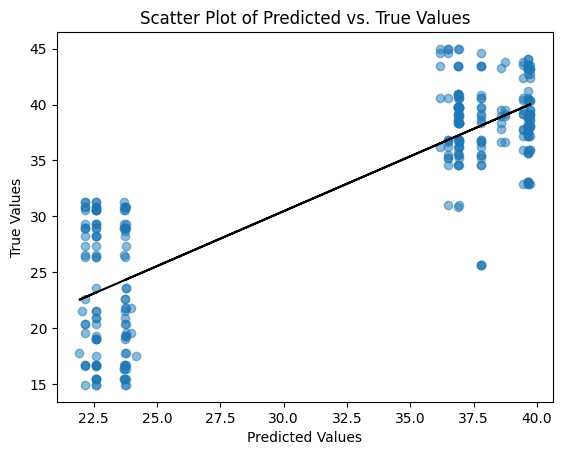

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# Tensorflow Model Architecture (25m only)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/dataframe_25m_fast_trial_2.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})


df

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 9847,Descriptors 9848,Descriptors 9849,Descriptors 9850,Descriptors 9851,Descriptors 9852,Descriptors 9853,Descriptors 9854,Descriptors 9855,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3226,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3227,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
3228,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [ ]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 1615 rows with NaN values in the Feature Extraction column.
Found 1615 rows with NaN values in the Descriptors column.


In [ ]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MaxAbsScaler


# Flatten the input sequences
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])

# Normalize the flattened sequences
scaler = MaxAbsScaler()

X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)


X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)



x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [ ]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [ ]:
hist = model.fit(X_train_padded, y_train,
                  epochs= 300, 
                  batch_size=64, 
                  verbose = 1, 
                  callbacks=[reduce_lr,early_stop], 
                  validation_data = (X_test_padded, y_test))

Epoch 1/300
21/21 [==============================] - 7s 125ms/step - loss: 36.7957 - val_loss: 99.2756 - lr: 0.0010
Epoch 2/300
21/21 [==============================] - 2s 97ms/step - loss: 24.9787 - val_loss: 99.6243 - lr: 0.0010
Epoch 3/300
21/21 [==============================] - 2s 98ms/step - loss: 19.0749 - val_loss: 99.7823 - lr: 0.0010
Epoch 4/300
21/21 [==============================] - 2s 99ms/step - loss: 17.4454 - val_loss: 99.6881 - lr: 0.0010
Epoch 5/300
21/21 [==============================] - 2s 100ms/step - loss: 17.8332 - val_loss: 99.5754 - lr: 0.0010
Epoch 6/300
21/21 [==============================] - 2s 99ms/step - loss: 19.5286 - val_loss: 99.2801 - lr: 0.0010
Epoch 7/300
21/21 [==============================] - 2s 98ms/step - loss: 17.9542 - val_loss: 99.2171 - lr: 0.0010
Epoch 8/300
21/21 [==============================] - 2s 98ms/step - loss: 14.7852 - val_loss: 98.8280 - lr: 0.0010
Epoch 9/300
21/21 [==============================] - 2s 98ms/step - loss: 14.8

Evaluate Model

In [ ]:

y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

11/11 [==============================] - 1s 12ms/step
MAPE: 0.1537627125222611


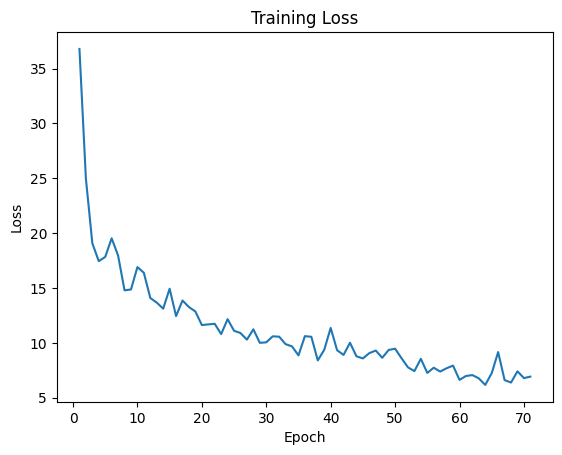

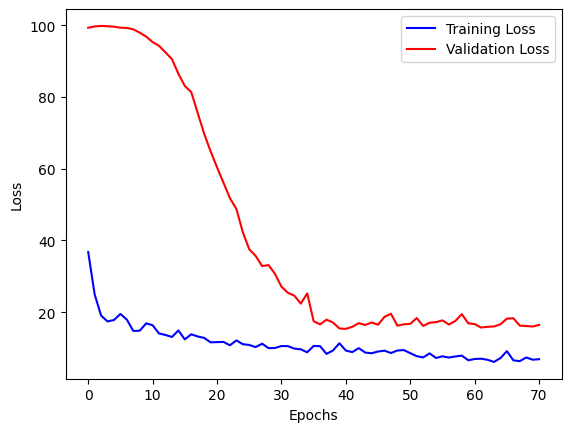

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting loss values from history
loss = hist.history['loss']

# Creating a Seaborn line plot
sns.lineplot(x=range(1, len(loss) + 1), y=loss)

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Displaying the plot
plt.show()

plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: 0.5784881053407218
Mean Absolute Error (MAE): 4.350915767681488
Root Mean Squared Error (RMSE): 5.580297124872377


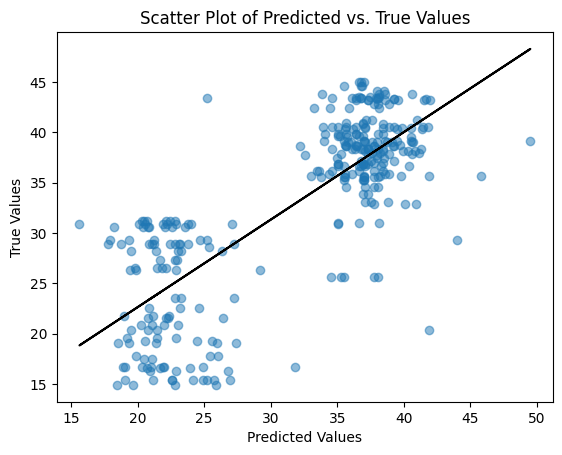

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


SVR 25m

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.5664764514705702


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5664764514705702
Mean Absolute Error (MAE): 4.534235320481676
Root Mean Squared Error (RMSE): 5.659248349919882
Mean Absolute Percentage Error (MAPE): 0.165934169899112


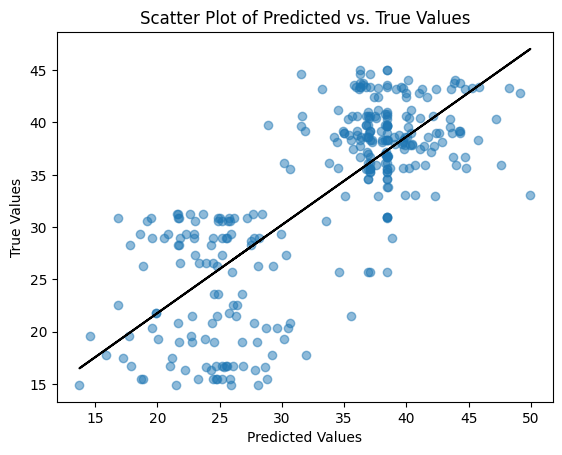

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.7217696359728033


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7217696359728033
Mean Absolute Error (MAE): 3.6901327586274095
Root Mean Squared Error (RMSE): 4.533719724505009
Mean Absolute Percentage Error (MAPE): 0.1364634623917744


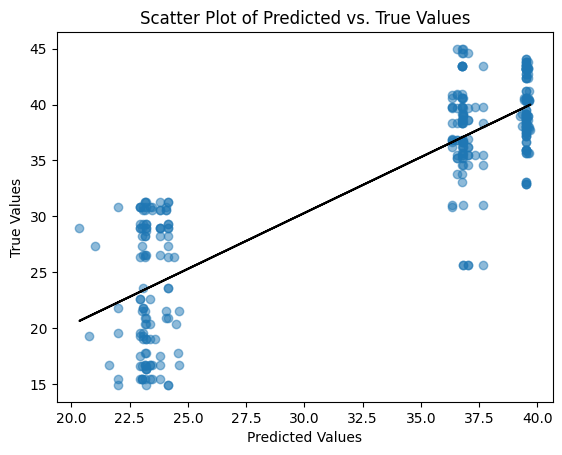

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()
